In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from LinearRegressionCustom import LinearRegression

# Exploratory Data Analysis

The csv-document is read with pandas and examined with .info()
The file contains 10 features, of which one is categorical, 20640 entries with some nulls in one of the features.

In [67]:
df = pd.read_csv("housing.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The feature "total_bedrooms" null-entries are filled with the median value.

In [68]:
df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The categorical feature "ocean_proximity" is one-hot encoded.

The one-hot encoded columns are colinear, and removal of one of the columns is desired. The multicolinearity makes the coefficients (beta) for each column unpredictable and their analysis meaningless. There is also a resulting increase of standard error, with the hightened variance. The p-values and variance could indicate an insignificance of a feature, that is not true. As well as missreadings of statistics, calculations dependent on inverses of matrices would be non-computable due to the perfect colinearity of the one-hot encoded variables.
After examining correlation between features, one of the categorical features shall be droped.

In [69]:
df_encoded = pd.get_dummies(df, columns=["ocean_proximity"], drop_first=False).astype(float)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   total_rooms                 20640 non-null  float64
 4   total_bedrooms              20640 non-null  float64
 5   population                  20640 non-null  float64
 6   households                  20640 non-null  float64
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  float64
 9   ocean_proximity_<1H OCEAN   20640 non-null  float64
 10  ocean_proximity_INLAND      20640 non-null  float64
 11  ocean_proximity_ISLAND      20640 non-null  float64
 12  ocean_proximity_NEAR BAY    20640 non-null  float64
 13  ocean_proximity_NEAR OCEAN  206

The data is scaled

In [70]:
for col in df_encoded.columns:
    df_encoded[col + "_scaled"] = (df_encoded[col] - df_encoded[col].mean())/df_encoded[col].std()
df_scaled = df_encoded[[col for col in df_encoded.columns if col.endswith("_scaled")]].astype(float)

The 14 features are examined visually with histograms. This way the distributions can be discearned.
The median_income feature is assumed to be distributed according to standard norm. As such it can be used as the respondent variabel Y.

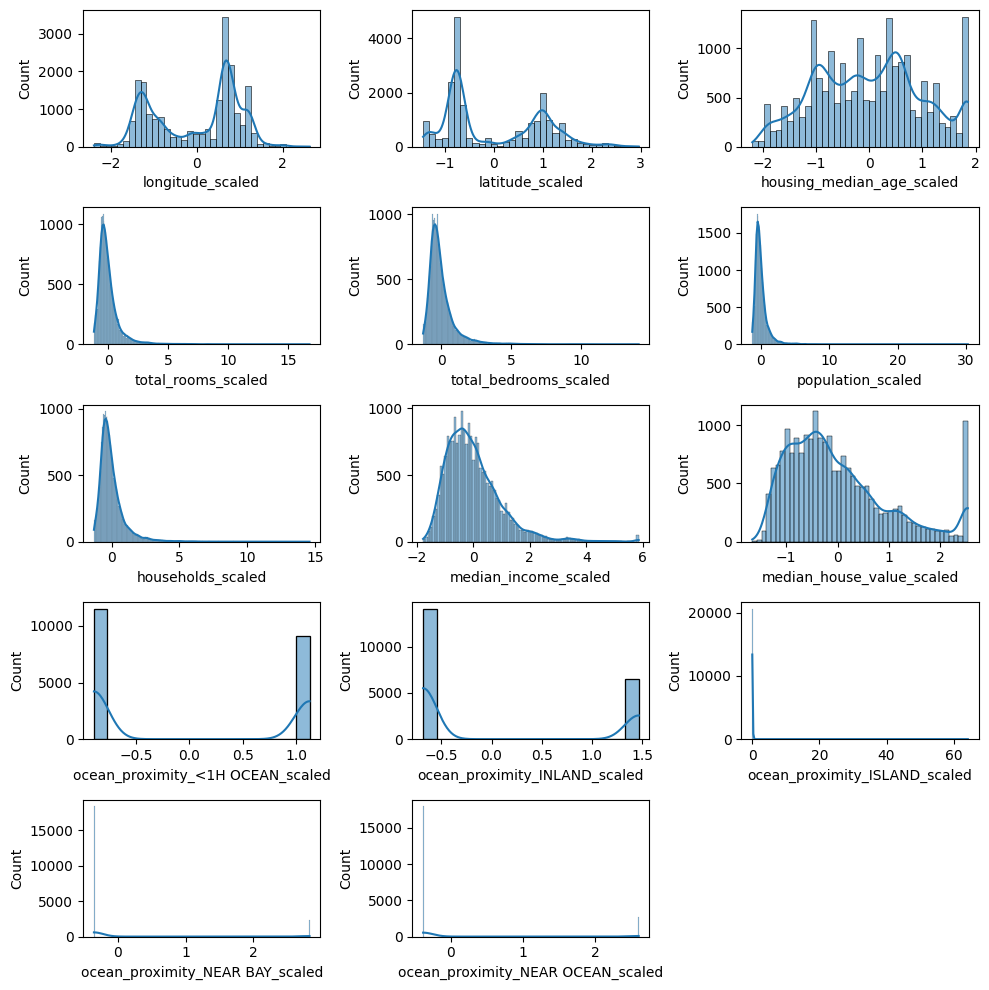

In [71]:
fig, axes = plt.subplots(5, 3, figsize=(10, 10))
axes = axes.flatten()
for i, col in enumerate(df_scaled.columns[0:14]):
    sns.histplot(df_scaled[col], kde=True, ax=axes[i])

for ax in axes[len(df_scaled.columns):]:
    ax.remove()

plt.tight_layout()
plt.show()

The model is set with "median_income_scaled" as respondent variable

In [72]:
model = LinearRegression()
fit = model.fit(
    X = (df_scaled.drop(columns=["median_income_scaled"])), 
    y = df_scaled["median_income_scaled"])

A heatmap of the correlation between features shows the significance of each feature.

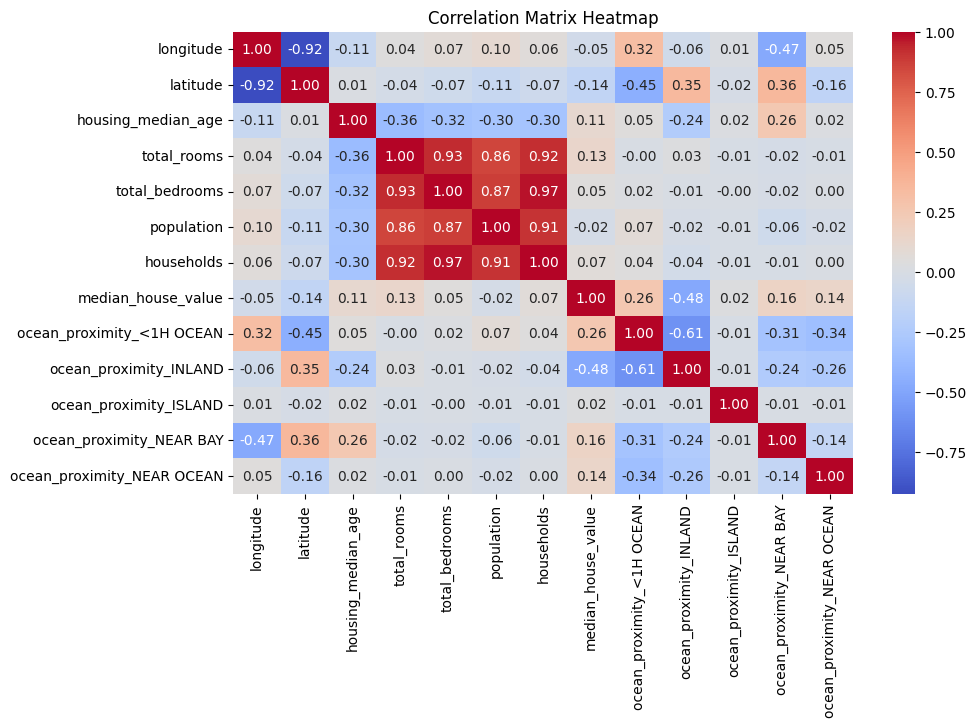

In [73]:
corr, prob_corr = model.pearson_correlation()

feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_house_value', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']
corr_df = pd.DataFrame(corr, index=feature_names, columns=feature_names)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_df, annot = True, fmt = ".2f", cmap = "coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

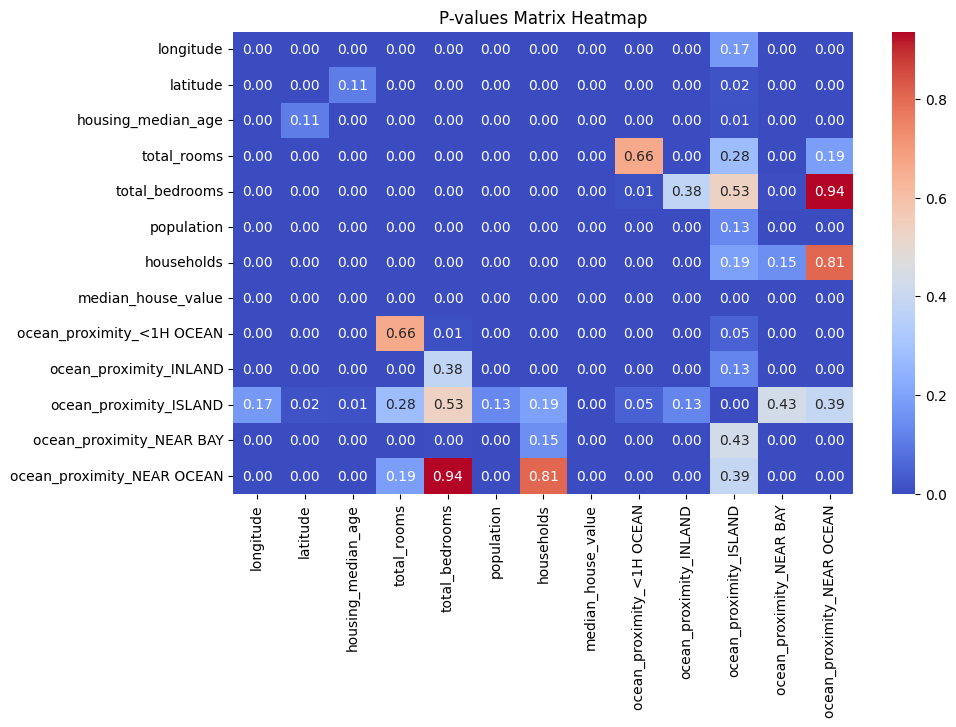

In [74]:
prob_corr_df = pd.DataFrame(prob_corr, index=feature_names, columns=feature_names)

plt.figure(figsize=(10, 6))
sns.heatmap(prob_corr_df, annot = True, fmt = ".2f", cmap = "coolwarm")
plt.title("P-values Matrix Heatmap")
plt.show()

The correlation values give reason to remove "ocean_proximity_ISLAND", "total_rooms" and "total_bedrooms". But the significance of the interactioneffekt of "total_rooms" and "total_bedrooms" shall be determined before removal.

In [75]:
df_scaled["ocean_proximity_ISLAND_scaled"].value_counts()

ocean_proximity_ISLAND_scaled
-0.015566     20635
 64.240175        5
Name: count, dtype: int64

There is not enough data in the ISLAND feature to merit significance. This column will be removed.

In [106]:
df_scaled["total_rooms_x_bedrooms"] = df_scaled["total_rooms_scaled"] * df_scaled["total_bedrooms_scaled"]

In [107]:
model = LinearRegression()
fit = model.fit(
    X = (df_scaled.drop(columns=["median_income_scaled", "ocean_proximity_ISLAND_scaled", "total_rooms_x_bedrooms"])), 
    y = df_scaled["median_income_scaled"]
)

In [108]:
model_interaction = LinearRegression()
fit = model_interaction.fit(
    X = (df_scaled.drop(columns=["median_income_scaled", "ocean_proximity_ISLAND_scaled"])), 
    y = df_scaled["median_income_scaled"])

With the new Interaction feature, the model is submitted to a t-test.

In [109]:
t_stats, prob_t = model_interaction.t_statistic()
print("t-statistics:", t_stats)
print("p-values:", prob_t)

t-statistics: [ 2.71620969e+00  5.81722319e-02 -1.09478576e+00 -2.91018742e+01
  7.86778178e+01 -4.34325972e+01  4.43440270e+00 -8.08327797e+00
  1.15212882e+02  4.72128284e+00  4.57727077e+00  4.65953339e+00
  4.09751140e+00 -1.06020741e+01]
p-values: [6.60891057e-003 9.53612003e-001 2.73623291e-001 1.64243416e-182
 0.00000000e+000 0.00000000e+000 9.28047700e-006 6.64941992e-016
 0.00000000e+000 2.35901685e-006 4.73829237e-006 3.18906523e-006
 4.19211244e-005 3.40405915e-026]


t-statistic shows the interaction as statistically significant. But seeing as the sample size n > 20000, the significance test in and of iteself holds little result.
The difference in R2 shall be examined.

In [110]:
R2_full = model_interaction.R_squared()
R2_reduced = model.R_squared()
R2_diff = R2_full - R2_reduced
print(f"R² for full model: {R2_full:.4f}")
print(f"R² for reduced model: {R2_reduced:.4f}")
print(f"Difference in R²: {R2_diff:.4f}")

R² for full model: 0.6557
R² for reduced model: 0.6539
Difference in R²: 0.0019


The differential in R2 shows the interactioneffect as statistically insignificant and the two features can as a result be removed.

In [123]:
model = LinearRegression()
fit = model.fit(
    X = (df_scaled.drop(columns=["median_income_scaled", "ocean_proximity_ISLAND_scaled", "total_rooms_scaled", "total_bedrooms_scaled", "total_rooms_x_bedrooms"])), 
    y = df_scaled["median_income_scaled"]
)

Now the model contains only features of interest for our model.

# Examination of statistics

### Examining the F-statistic and t-statistic

In [124]:
F, prob_F = model.F_Statistic()
print("F-statistic:", F)
print(f"p_value: {prob_F:.2e}")

F-statistic: 2450.5331178974593
p_value: 0.00e+00


In [125]:
t_stats, prob_t = model.t_statistic()
print("t-statistics:", t_stats)
print("p-values:", prob_t)

t-statistics: [-2.54298251e-14  3.61525924e+00  3.77736964e+00 -3.92959364e+01
  2.59539255e+01 -3.19153332e+01  1.39428806e+02  4.97368317e+00
  5.33662360e+00  5.06456947e+00  4.50234111e+00]
p-values: [1.00000000e+000 3.00761776e-004 1.58938489e-004 0.00000000e+000
 3.62838811e-146 3.24779671e-218 0.00000000e+000 6.62203106e-007
 9.56929215e-008 4.12850934e-007 6.75768965e-006]


The results of the F-test and t-test concurrs with the assumption of significance for each feature.

### Examining the Coefficient of Determination

In [126]:
R2 = model.R_squared()
print(f"R-squared: {R2:.4f}")

R-squared: 0.5429


The R2 variabel tells us that the model explains 54% of the variation of y (median income). 
It also gives us our significance-interval of 54% and its correlating alpha 0.46

### Examining coefficient estimates with a 54% confidence intervals.

In [128]:
df_scaled.columns

Index(['longitude_scaled', 'latitude_scaled', 'housing_median_age_scaled',
       'total_rooms_scaled', 'total_bedrooms_scaled', 'population_scaled',
       'households_scaled', 'median_income_scaled',
       'median_house_value_scaled', 'ocean_proximity_<1H OCEAN_scaled',
       'ocean_proximity_INLAND_scaled', 'ocean_proximity_ISLAND_scaled',
       'ocean_proximity_NEAR BAY_scaled', 'ocean_proximity_NEAR OCEAN_scaled',
       'total_rooms_x_bedrooms'],
      dtype='object')

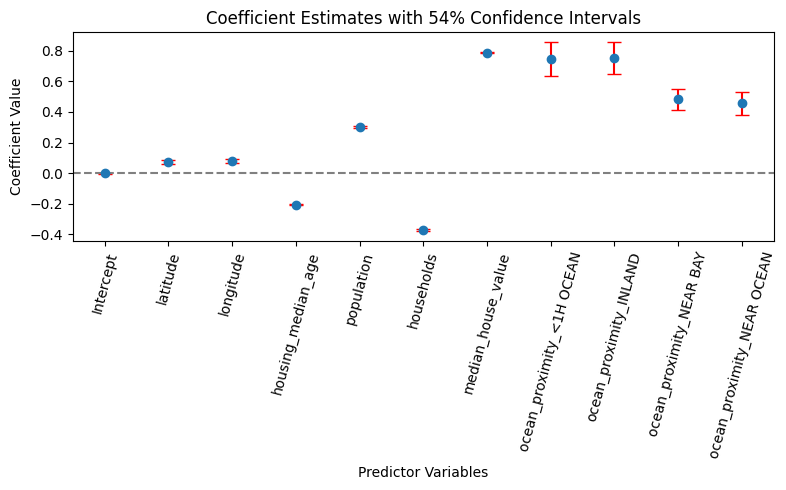

In [138]:
lower, upper = model.confidence_intervals(alpha = 0.46)
beta = model.beta

plt.figure(figsize=(8, 5))
plt.errorbar(x=np.arange(len(beta)), y=beta, yerr=[beta - lower, upper - beta], fmt='o', ecolor='red', capsize=5)
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(np.arange(len(beta)), ['Intercept', 'latitude', 'longitude', 'housing_median_age', 'population', 'households', 'median_house_value', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'], rotation=75)
plt.title('Coefficient Estimates with 54% Confidence Intervals')
plt.xlabel('Predictor Variables')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

The graph gives a visual of the effect each parameter has on the respondent variable. median_house_value holds the greatest positive effect, with ocean proximity: <1H and INLAND following suit with high effect aswell. NEAR_BAY and NEAR_OCEAN and population holds medium positive effect. Households hold a high negative effect and housing_median_age a medium negative effect. latitude and longitude are not very effective.

### Examining the significance and confidence level.

In [140]:
alpha = 0.46
if prob_F < alpha:
    print("The model is statistically significant at 54% confidence level.")
if np.any(prob_t < alpha):
    print("The coefficient is statistically significant at 54% confidence level.")
if np.any(prob_corr < alpha):
    print("There are statistically significant correlations between the features at 54% confidence level.")

The model is statistically significant at 54% confidence level.
The coefficient is statistically significant at 54% confidence level.
There are statistically significant correlations between the features at 54% confidence level.


# Conclusion

The model holds statistiscal significance at 54% confidence level, meaning that it is a moderatly reliable predicator for the data.
